# Program pro vyšlechtění optimální klávesnice pro český jazyk genetickým algoritmem


Michal Seibert (seibemic@fit.cvut.cz)

Import knihoven

In [97]:
import math
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import re
import PyPDF2

Obrázek pro zobrazení pravidel psaní všemi deseti

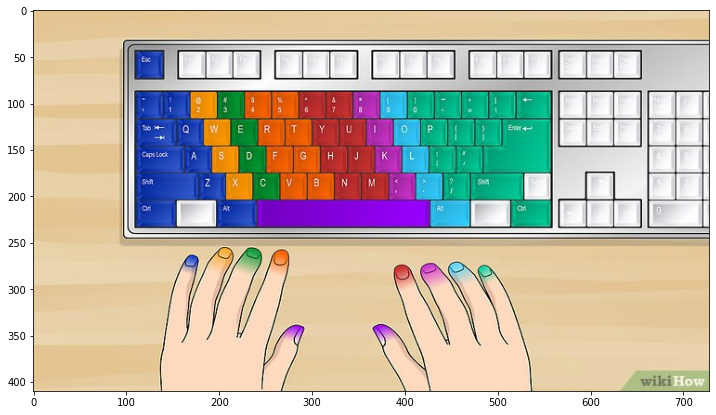

In [98]:
img = mpimg.imread('rules.jpg')
plt.figure(figsize=(14,7))
plt.imshow(img)

Třída Finger rezprezentuje jeden prst ruky. 

In [99]:
class Finger:
    def __init__(self, startX, startY):
        self.posX=startX   # aktuální X pozice prstu
        self.posY=startY   # aktuální Y pozice prstu
        self.count=0       # celkový počet úderů prstu na klávesnici
        
    # metoda k výpočtu fitness během přesunu prstu k další klávese
    def getDistanceWithCounts(self,X,Y,armSum, allSum, sameFinger):
        self.count+=1
        s=1
        if(armSum!=0 and allSum!=0):
            k=2-((allSum-armSum)/allSum)-((armSum-self.count)/armSum)
        else:
            k=1
        if(sameFinger):
            s=1.2
        if(X==self.posX and Y==self.posY):
            return 0
        if(Y==self.posY):
            res=20.12*abs(X-self.posX)
            self.posX=X
            return k*res*s
        if(X==self.posX):
            res=18*abs(Y-self.posY)
            self.posY=Y
            return k*res*s
        if(abs(X-self.posX)==1):
            self.posX=X
            self.posY=Y
            return k*20.12*s
        if(abs(X-self.posX)==2):
            self.posX=X
            self.posY=Y
            return k*36*s
        if(abs(X-self.posX)==3):
            self.posX=X
            self.posY=Y
            return k*54.75*s
        

Třída Jedinec obsahuje operátory inicializace, crossover, mutace a výpočet fitness.

In [100]:
class Individual:
    def __init__(self, keyboard, mother,father,mutateRate,file):
        self.mutateRate=mutateRate
        
        self.allChars=["+","ě","š","č","ř","ž","ý","á","í","é","=",
                       "q","w","e","r","t","z","u","i","o","p","ú",
                       "a","s","d","f","g","h","j","k","l","ů",
                       "y","x","c","v","b","n","m",",",".","-"] # všechny povolené znaky
        self.fingers=[] # list prstů
        for i in range(0,8):
            if(i<4):
                f=Finger(2,i)
                self.fingers.append(f)
            else:
                f=Finger(2,i+3)
                self.fingers.append(f)
                
        self.fitness=0   # fitness jedince
        self.keyboard=[] # fenotyp jedince
        
        # provedení inicializace - náhodná, nebo pomocí crossoveru, pokud jsou matka a otec k dispozici
        if(keyboard==None):
            if(mother!=None and father!=None):
                self.crossover(mother,father)
            else:
                self.initializeIndividual()
        elif(keyboard):
            self.keyboard=keyboard.copy()
        else:
            raise TypeError("No keyboard to init")
        self.mutate()  #mutace jedince
        self.calculateFitness(file) # výpočet fitness jedince

        
        # operátor crossover - prvních 5 znaků z každé řádky matky, zbytek z otce
    def crossover(self,mother,father):
        father=list(np.concatenate(father).flat)
        for i in range(0,4):
            self.keyboard.append(mother[i][:5])
        for line in self.keyboard:
            for x in line:
                if x in father:
                    father.remove(x)
                       
        for i in range(5,11):
            self.keyboard[0].append(father[0])
            father.remove(father[0])
        for i in range(5,11):
            self.keyboard[1].append(father[0])
            father.remove(father[0])
        for i in range(5,10):
            self.keyboard[2].append(father[0])
            father.remove(father[0])
        for i in range(5,10):
            self.keyboard[3].append(father[0])
            father.remove(father[0])

        # náhodná inicializace jedince
    def initializeIndividual(self):
        chars=self.allChars.copy()
        for rowlen in [11,11,10,10]:
            keyboardLine=[]
            for i in range(0,rowlen):
                c=chars[random.randint(0, len(chars)-1)]
                chars.remove(c)
                keyboardLine.append(c)
            self.keyboard.append(keyboardLine)
            
        # mutace - náhodné prohození dvou kláves
    def swapKeys(self,X1,Y1,X2,Y2):
        tmpChar=self.keyboard[X1][Y1]
        self.keyboard[X1][Y1]=self.keyboard[X2][Y2]
        self.keyboard[X2][Y2]=tmpChar
    def mutate(self):
        if(random.uniform(0, 1)<=self.mutateRate):
            key1X=random.randint(0,3)
            key1Y=random.randint(0,len(self.keyboard[key1X])-1)
            key2X=random.randint(0,3)
            key2Y=random.randint(0,len(self.keyboard[key2X])-1)
            self.swapKeys(key1X,key1Y,key2X,key2Y)
            
        # zvolení, který prst má provést další stisk klávesy při vpočtu fitness
    def chooseFinger(self,y):
        #list of fingers
        if(y<4):
            return y
        if(y==4):
            return y-1
        if(y==5):
            return y-1
        if(y>9):
            return 7
        if(y>5):
            return y-2
        
        # výpočet fitness
    def calculateFitness(self, file):
        prevFinger=-1
        for char in file:
            for line in range(0,4):
                if(char in self.keyboard[line]):
                    chosenFinger=self.chooseFinger(self.keyboard[line].index(char))
                    armSum=0
                    allSum=0                   
                    if(chosenFinger<4):
                        for i in range(0,int(len(self.fingers)/2)):
                            armSum+=self.fingers[i].count
                    else:
                        for i in range(int(len(self.fingers)/2),len(self.fingers)):
                            armSum+=self.fingers[i].count
                    for i in range(0,len(self.fingers)):
                        allSum+=self.fingers[i].count
                    
                    self.fitness+=self.fingers[chosenFinger].getDistanceWithCounts(line,
                                                                                   self.keyboard[line].index(char),
                                                                                  armSum, allSum,prevFinger==chosenFinger)
                    prevFinger=chosenFinger


Třída Populace, obsahuje volbu jedinců do další generace a ruletový operátor.

In [149]:
class Population:
    # inicializace
    def __init__(self, size,previousPopulation,mutateRate,file):
        self.populationSize=size
        self.mutateRate=mutateRate
        self.population=[]
        self.prevPopulation=previousPopulation
        self.populationFitness=0
        self.file=file
        self.makePopulation()
        self.calculatePopulationFitness()
    # výběr N nejlepších jedinců z populace
    def selectNBest(self,n):
        fs=[]
        for i in range(0,self.prevPopulation.populationSize):
            fs.append(self.prevPopulation.population[i].fitness)
        fs=sorted(fs)
        fs=fs[:n]
        count=0
        for i in range(0,self.prevPopulation.populationSize):
            if (count<n):
                if self.prevPopulation.population[i].fitness in fs:
                    self.population.append(self.prevPopulation.population[i])
                    count+=1
            else:
                break
        return count
     # tvorba nové populace - z N nejlepších, ruletou a jejich křížením
    def makePopulation(self):
        if self.prevPopulation==None:
            for i in range(0,self.populationSize):
                self.population.append(Individual(None,None,None, self.mutateRate,self.file))
        else:
            n=self.selectNBest(int(self.populationSize/10))
            k=int(self.populationSize/2)
            self.roulette(k)
                
            for i in range(0,self.populationSize-k-n):
                mother=self.population[random.randint(0,k-n-1)].keyboard
                father=self.population[random.randint(0,k-n-1)].keyboard
                self.population.append(Individual(None,mother,father, self.mutateRate,self.file))
                
        # ruleta
    def roulette(self,k):
        idx=0
        fs=[]
        for i in range(0,len(self.prevPopulation.population)):
            fs.append(self.prevPopulation.population[i].fitness)
        MaxMin=max(fs)+min(fs)
        for i in range(0,k):
            randnum=random.uniform(0, 1)*self.prevPopulation.populationFitness
            for idx in range(0,self.populationSize):
                if(randnum<0):
                    break
                randnum-=(MaxMin-self.prevPopulation.population[idx].fitness)
                
                           
            self.population.append(Individual(self.prevPopulation.population[idx-1].keyboard,None,None, self.mutateRate,self.file))

        # výpočet celkové fitness populace
    def calculatePopulationFitness(self):
        for i in range(0,self.populationSize):
            self.populationFitness+=self.population[i].fitness
         #výběr nejlepšího jedince z populace
    def getBestFromPopulation(self,getKeyboard):
        fs=[]
        for i in range(0,self.populationSize):
            fs.append(self.population[i].fitness)  
        if(getKeyboard):
            return min(fs), self.population[np.argmin(fs)].keyboard, self.population[np.argmin(fs)].fingers
        return min(fs)


Třída Evoluce - zajišťuje běh genetického algoritmu, načtení textu, z kterého je počítána fitness a výběr jednotlivých populací.

In [102]:
class Evolution:
    # inicializace
    def __init__(self, numberOfGenerations,file):
        self.numOfGens=numberOfGenerations
        self.fileName=file
        self.file=""
        self.allChars=["+","ě","š","č","ř","ž","ý","á","í","é","=",
                       "q","w","e","r","t","z","u","i","o","p","ú",
                       "a","s","d","f","g","h","j","k","l","ů",
                       "y","x","c","v","b","n","m",",",".","-"]
        self.Populations=[]
        # načtení souboru
    def loadFile(self):
        with open(self.fileName, 'r') as file:
            self.file = file.read()
        # načtení znaků ze souboru
    def loadChars(self):
        self.loadFile()
        sub=""
        for char in self.allChars:
            sub+=char
        self.file=self.file.lower()
        self.file=re.sub(f"[^{sub}]","",self.file)
        # rozběhnutí genetického algoritmu
    def runEvolution(self,populationSize):
        print("generation:  0")
        self.Populations.append(Population(populationSize,None,0.1,self.file))
        for i in range(1,self.numOfGens):
            print("generation: ",i)
            self.Populations.append(Population(populationSize,self.Populations[i-1],0.1,self.file))
        # vypsání fitness všech populací a jejich nejlepších jedinců
    def getPopulationsFitness(self):
        for i in range(0,self.numOfGens):
            print("generation: ",i)
            print("     fitness sum: ", self.Populations[i].populationFitness)
            print("     best of generation: ",self.Populations[i].getBestFromPopulation(False))
        # getter pro vrácení poslední populace
    def getFinalPopulation(self):
        minF, keyboard, fingers=self.Populations[self.numOfGens-1].getBestFromPopulation(True)
        return minF,keyboard, fingers
        # getter pro vrácení fitness všech populací
    def getAllPopulationsFitness(self):
        bestFitness=[]
        popFitness=[]
        for i in range(0,self.numOfGens):
            popFitness.append(self.Populations[i].populationFitness)
            bestFitness.append(self.Populations[i].getBestFromPopulation(False))
        return bestFitness, popFitness


### Běh algoritmu pro data z odborného textu

In [54]:
numberOfGenerations=150  # počet generací
populationSize=300       # velikost populace
e=Evolution(numberOfGenerations,"./Data/thesis.txt")
e.loadChars()
e.runEvolution(populationSize)
e.getPopulationsFitness()

generation:  0
generation:  1
generation:  2
generation:  3
generation:  4
generation:  5
generation:  6
generation:  7
generation:  8
generation:  9
generation:  10
generation:  11
generation:  12
generation:  13
generation:  14
generation:  15
generation:  16
generation:  17
generation:  18
generation:  19
generation:  20
generation:  21
generation:  22
generation:  23
generation:  24
generation:  25
generation:  26
generation:  27
generation:  28
generation:  29
generation:  30
generation:  31
generation:  32
generation:  33
generation:  34
generation:  35
generation:  36
generation:  37
generation:  38
generation:  39
generation:  40
generation:  41
generation:  42
generation:  43
generation:  44
generation:  45
generation:  46
generation:  47
generation:  48
generation:  49
generation:  50
generation:  51
generation:  52
generation:  53
generation:  54
generation:  55
generation:  56
generation:  57
generation:  58
generation:  59
generation:  60
generation:  61
generation:  62
ge

In [88]:
bestFit_thesis,popFit_thesis=e.getAllPopulationsFitness()
minFit_thesis,keyboard_thesis,fingers_thesis=e.getFinalPopulation()

In [89]:
def flatten(l):
    new_list = []
    for i in l:
        for j in i:
            new_list.append(j)
    return new_list

In [90]:
keyboard_thesis=flatten(keyboard_thesis)

In [91]:
from PIL import Image, ImageFont, ImageDraw 

image = Image.open("keyboard.png") 
draw = ImageDraw.Draw(image) 

font = ImageFont.truetype("arial.ttf", 35) 
y=0
x=0
offsets=[0,34,51,85]
for counter, char in enumerate(keyboard_thesis):
    if(counter==11 or counter==22 or counter==32):
        y+=1
        x=0
    draw.text((68*x+92+offsets[y], 68*y+15), char,font=font, fill ="black", align ="left") 
    x+=1
image.show() 
image.save("ThesisKeyboard.png")

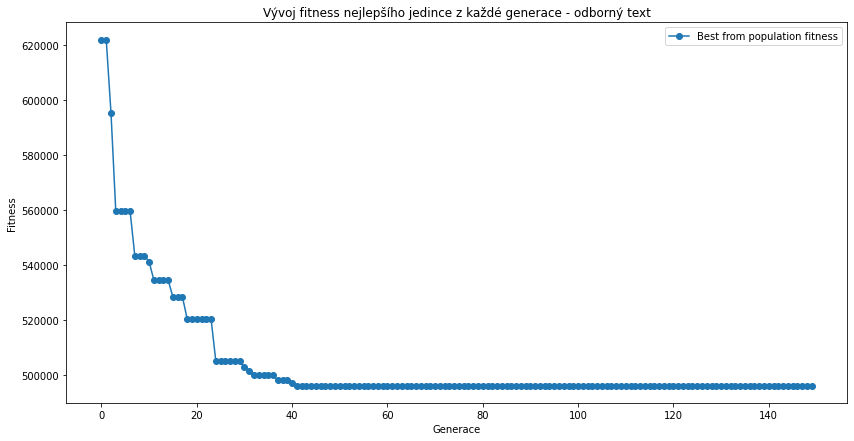

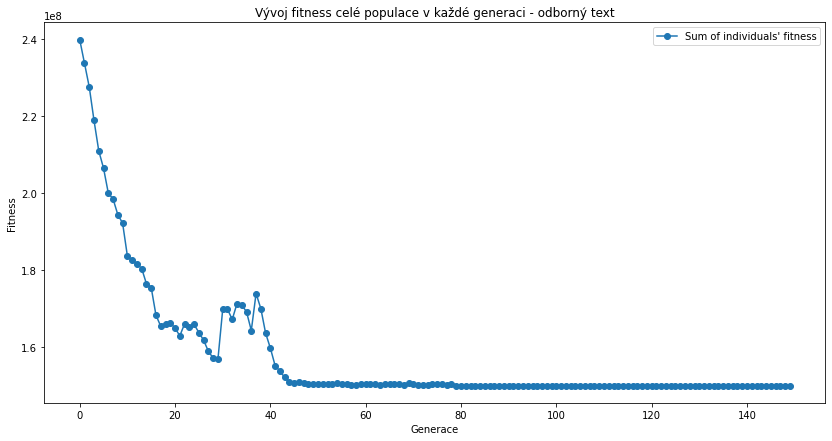

In [87]:
plt.figure(figsize=(14,7))
plt.title("Vývoj fitness nejlepšího jedince z každé generace - odborný text")
plt.plot(range(numberOfGenerations), bestFit_thesis, 'o-',label="Best from population fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.savefig("thesis_bestIndividual.png")
plt.show()


plt.figure(figsize=(14,7))
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Vývoj fitness celé populace v každé generaci - odborný text")
plt.plot(range(numberOfGenerations),popFit_thesis,"o-", label="Sum of individuals' fitness")
plt.legend()
plt.savefig("thesis_sumFitness.png")
plt.show()

rozložení zatížení prstů

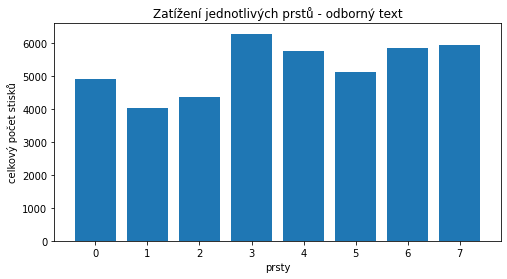

In [140]:
thesis_fingersCounts=[]
for i in range(len(fingers_thesis)):
    thesis_fingersCounts.append(fingers_thesis[i].count)
plt.figure(figsize=(8,4))
plt.xlabel("prsty")
plt.ylabel("celkový počet stisků")
plt.title("Zatížení jednotlivých prstů - odborný text")
plt.bar(range(len(thesis_fingersCounts)), thesis_fingersCounts)
plt.savefig("thesis_zatizeniPrstu.jpg")
plt.show()

### Běh algoritmu pro data z pohádek

In [55]:
numberOfGenerations=100
populationSize=300
e2=Evolution(numberOfGenerations,"./Data/pohadky.txt")
e2.loadChars()
e2.runEvolution(populationSize)
e2.getPopulationsFitness()

generation:  0
generation:  1
generation:  2
generation:  3
generation:  4
generation:  5
generation:  6
generation:  7
generation:  8
generation:  9
generation:  10
generation:  11
generation:  12
generation:  13
generation:  14
generation:  15
generation:  16
generation:  17
generation:  18
generation:  19
generation:  20
generation:  21
generation:  22
generation:  23
generation:  24
generation:  25
generation:  26
generation:  27
generation:  28
generation:  29
generation:  30
generation:  31
generation:  32
generation:  33
generation:  34
generation:  35
generation:  36
generation:  37
generation:  38
generation:  39
generation:  40
generation:  41
generation:  42
generation:  43
generation:  44
generation:  45
generation:  46
generation:  47
generation:  48
generation:  49
generation:  50
generation:  51
generation:  52
generation:  53
generation:  54
generation:  55
generation:  56
generation:  57
generation:  58
generation:  59
generation:  60
generation:  61
generation:  62
ge

In [93]:
bestFit_tales,popFit_tales=e2.getAllPopulationsFitness()
minFit_tales,keyboard_tales,fingers_tales=e2.getFinalPopulation()

In [94]:
keyboard_tales=flatten(keyboard_tales)

In [95]:
image = Image.open("keyboard.png") 
draw = ImageDraw.Draw(image) 

font = ImageFont.truetype("arial.ttf", 35) 
y=0
x=0
offsets=[0,34,51,85]
for counter, char in enumerate(keyboard_tales):
    if(counter==11 or counter==22 or counter==32):
        y+=1
        x=0
    draw.text((68*x+92+offsets[y], 68*y+15), char,font=font, fill ="black", align ="left") 
    x+=1
image.show() 
image.save("TalesKeyboard.png")

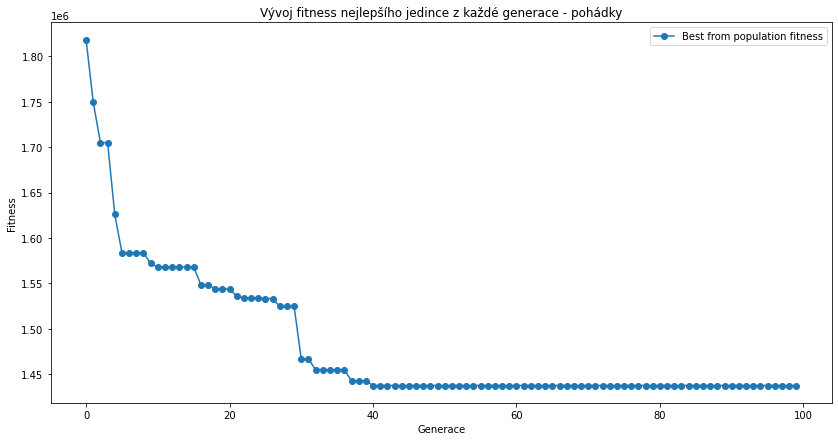

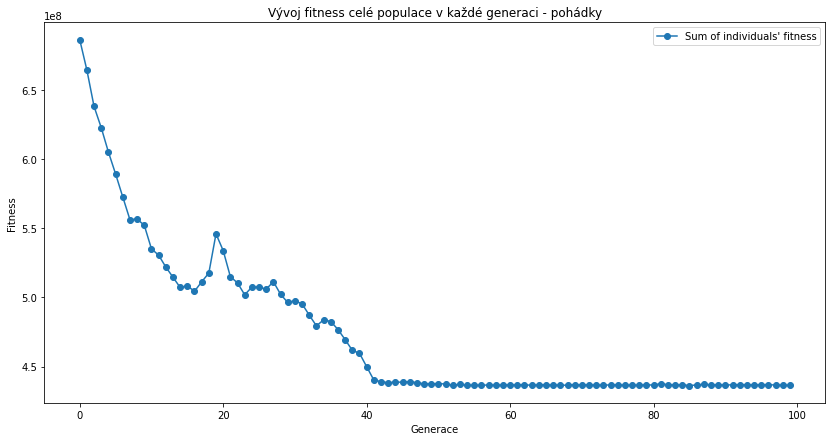

In [104]:
plt.figure(figsize=(14,7))
plt.title("Vývoj fitness nejlepšího jedince z každé generace - pohádky")
plt.plot(range(numberOfGenerations), bestFit_tales, 'o-',label="Best from population fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.savefig("tales_bestIndividual.png")
plt.show()


plt.figure(figsize=(14,7))
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Vývoj fitness celé populace v každé generaci - pohádky")
plt.plot(range(numberOfGenerations),popFit_tales,"o-", label="Sum of individuals' fitness")
plt.legend()
plt.savefig("tales_sumFitness.png")
plt.show()

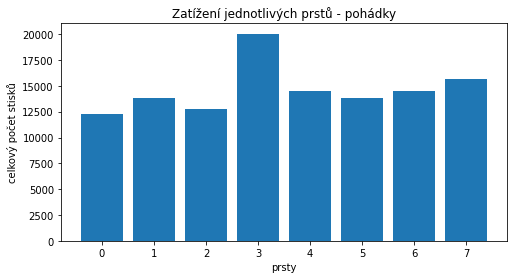

In [144]:
tales_fingersCounts=[]
for i in range(len(fingers_tales)):
    tales_fingersCounts.append(fingers_tales[i].count)
plt.figure(figsize=(8,4))
plt.xlabel("prsty")
plt.ylabel("celkový počet stisků")
plt.title("Zatížení jednotlivých prstů - pohádky")
plt.bar(range(len(tales_fingersCounts)), tales_fingersCounts)
plt.savefig("tales_zatizeniPrstu.jpg")
plt.show()

### qwerty

In [107]:
allChars=["+","ě","š","č","ř","ž","ý","á","í","é","=",
                       "q","w","e","r","t","z","u","i","o","p","ú",
                       "a","s","d","f","g","h","j","k","l","ů",
                       "y","x","c","v","b","n","m",",",".","-"]
def loadFile(fileName):
    with open(fileName, 'r') as file:
        f = file.read()
    return f
       
def loadChars(fileName):
    text=loadFile(fileName)
    sub=""
    for char in allChars:
        sub+=char
    text=text.lower()
    text=re.sub(f"[^{sub}]","",text)
    return text
f=loadChars("./Data/thesis.txt")

In [109]:
qwertyLayout=[["+","ě","š","č","ř","ž","ý","á","í","é","="],
                       ["q","w","e","r","t","z","u","i","o","p","ú"],
                       ["a","s","d","f","g","h","j","k","l","ů"],
                       ["y","x","c","v","b","n","m",",",".","-"]]

In [115]:
qwerty=Individual(qwertyLayout,None,None,0,f)
qwerty.calculateFitness(f)
print(qwerty.fitness)

1362093.473050686


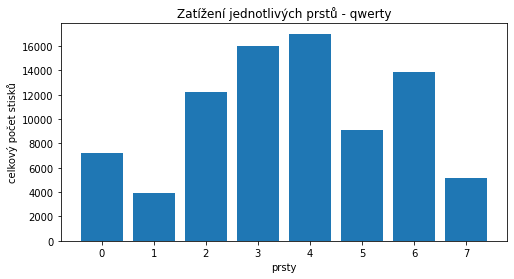

In [143]:
qwerty_fingersCounts=[]
for i in qwerty.fingers:
    qwerty_fingersCounts.append(i.count)
plt.figure(figsize=(8,4))
plt.xlabel("prsty")
plt.ylabel("celkový počet stisků")
plt.title("Zatížení jednotlivých prstů - qwerty")
plt.bar(range(len(qwerty_fingersCounts)), qwerty_fingersCounts)
plt.savefig("qwerty_zatizeniPrstu.jpg")
plt.show()

### Dvorak

In [117]:
DvorakLayout=[["+","ě","š","č","ř","ž","ý","á","í","é","="],
              [",",".","p","y","f","g","c","r","l","-","ú"],
              ["a","o","e","u","i","d","h","t","n","ů"],
              ["q","j","k","x","b","m","w","v","z","s"]]

In [118]:
dvorak=Individual(DvorakLayout,None,None,0,f)
dvorak.calculateFitness(f)
print(dvorak.fitness)

1304006.5258461658


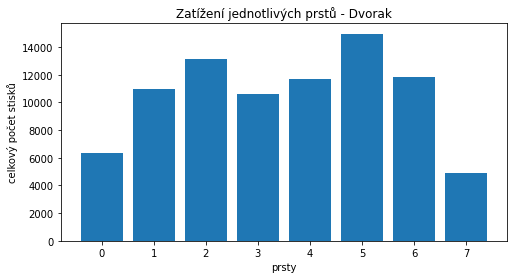

In [145]:
dvorak_fingersCounts=[]
for i in dvorak.fingers:
    dvorak_fingersCounts.append(i.count)
plt.figure(figsize=(8,4))
plt.xlabel("prsty")
plt.ylabel("celkový počet stisků")
plt.title("Zatížení jednotlivých prstů - Dvorak")
plt.bar(range(len(dvorak_fingersCounts)), dvorak_fingersCounts)
plt.savefig("dvorak_zatizeniPrstu.jpg")
plt.show()

### Colemak

In [128]:
ColemakLayout=[["+","ě","š","č","ř","ž","ý","á","í","é","="],
              ["q","w","f","p","g","j","l","u","y","ů","ú"],
              ["a","r","s","t","d","h","n","e","i","o"],
              ["z","x","c","v","b","k","m",",",".","-"]]

In [129]:
colemak=Individual(ColemakLayout,None,None,0,f)
colemak.calculateFitness(f)
print(colemak.fitness)

1286288.5485432167


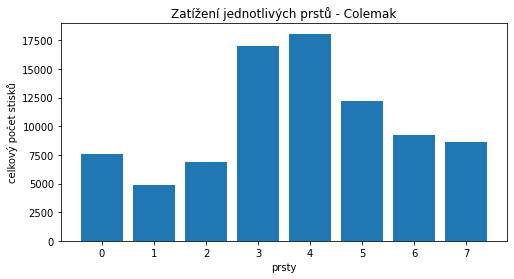

In [147]:
colemak_fingersCounts=[]
for i in colemak.fingers:
    colemak_fingersCounts.append(i.count)
plt.figure(figsize=(8,4))
plt.xlabel("prsty")
plt.ylabel("celkový počet stisků")
plt.title("Zatížení jednotlivých prstů - Colemak")
plt.bar(range(len(colemak_fingersCounts)), colemak_fingersCounts)
plt.savefig("colemak_zatizeniPrstu.jpg")
plt.show()

### Porovnání fitness

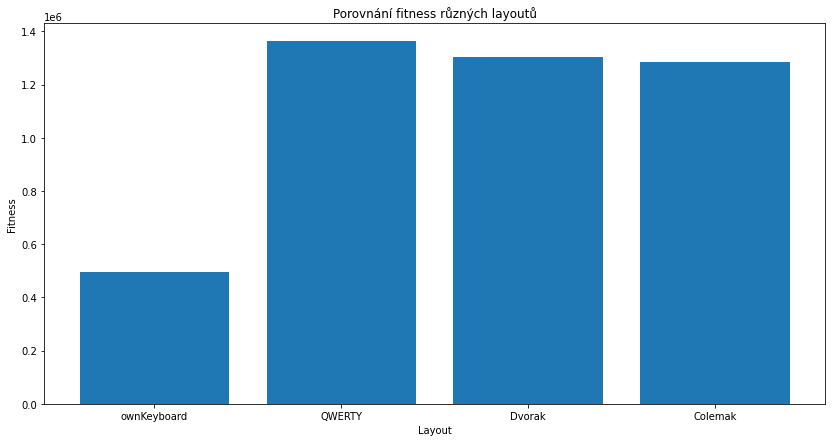

In [135]:
plt.figure(figsize = (14, 7))
plt.ylabel("Fitness")
plt.xlabel("Layout")
plt.title("Porovnání fitness různých layoutů")
plt.bar(["ownKeyboard","QWERTY","Dvorak","Colemak"],[minFit_thesis,qwerty.fitness,dvorak.fitness,colemak.fitness])
plt.savefig("comparison.jpg")
plt.show()

### Vytvoření klávesnice bez žádných speciálních znaků

In [154]:
class Individual2:
    def __init__(self, keyboard, mother,father,mutateRate,file):
        self.mutateRate=mutateRate
        
        self.allChars=["ě","š","č","ř","ž","ý","á","í","é", #-2
                       "q","w","e","r","t","z","u","i","o","p","ú",
                       "a","s","d","f","g","h","j","k","l","ů",
                       "y","x","c","v","b","n","m"] # všechny povolené znaky #-3
        self.fingers=[] # list prstů
        for i in range(0,8):
            if(i<4):
                f=Finger(2,i)
                self.fingers.append(f)
            else:
                f=Finger(2,i+3)
                self.fingers.append(f)
                
        self.fitness=0   # fitness jedince
        self.keyboard=[] # fenotyp jedince
        
        # provedení inicializace - náhodná, nebo pomocí crossoveru, pokud jsou matka a otec k dispozici
        if(keyboard==None):
            if(mother!=None and father!=None):
                self.crossover(mother,father)
            else:
                self.initializeIndividual()
        elif(keyboard):
            self.keyboard=keyboard.copy()
        else:
            raise TypeError("No keyboard to init")
        self.mutate()  #mutace jedince
        self.calculateFitness(file) # výpočet fitness jedince

        
        # operátor crossover - prvních 5 znaků z každé řádky matky, zbytek z otce
    def crossover(self,mother,father):
        father=list(np.concatenate(father).flat)
        for i in range(0,4):
            self.keyboard.append(mother[i][:5])
        for line in self.keyboard:
            for x in line:
                if x in father:
                    father.remove(x)
                       
        for i in range(5,9):
            self.keyboard[0].append(father[0])
            father.remove(father[0])
        for i in range(5,11):
            self.keyboard[1].append(father[0])
            father.remove(father[0])
        for i in range(5,10):
            self.keyboard[2].append(father[0])
            father.remove(father[0])
        for i in range(5,7):
            self.keyboard[3].append(father[0])
            father.remove(father[0])

        # náhodná inicializace jedince
    def initializeIndividual(self):
        chars=self.allChars.copy()
        for rowlen in [9,11,10,7]:
            keyboardLine=[]
            for i in range(0,rowlen):
                c=chars[random.randint(0, len(chars)-1)]
                chars.remove(c)
                keyboardLine.append(c)
            self.keyboard.append(keyboardLine)
            
        # mutace - náhodné prohození dvou kláves
    def swapKeys(self,X1,Y1,X2,Y2):
        tmpChar=self.keyboard[X1][Y1]
        self.keyboard[X1][Y1]=self.keyboard[X2][Y2]
        self.keyboard[X2][Y2]=tmpChar
    def mutate(self):
        if(random.uniform(0, 1)<=self.mutateRate):
            key1X=random.randint(0,3)
            key1Y=random.randint(0,len(self.keyboard[key1X])-1)
            key2X=random.randint(0,3)
            key2Y=random.randint(0,len(self.keyboard[key2X])-1)
            self.swapKeys(key1X,key1Y,key2X,key2Y)
            
        # zvolení, který prst má provést další stisk klávesy při vpočtu fitness
    def chooseFinger(self,y):
        #list of fingers
        if(y<4):
            return y
        if(y==4):
            return y-1
        if(y==5):
            return y-1
        if(y>9):
            return 7
        if(y>5):
            return y-2
        
        # výpočet fitness
    def calculateFitness(self, file):
        prevFinger=-1
        for char in file:
            for line in range(0,4):
                if(char in self.keyboard[line]):
                    chosenFinger=self.chooseFinger(self.keyboard[line].index(char))
                    armSum=0
                    allSum=0                   
                    if(chosenFinger<4):
                        for i in range(0,int(len(self.fingers)/2)):
                            armSum+=self.fingers[i].count
                    else:
                        for i in range(int(len(self.fingers)/2),len(self.fingers)):
                            armSum+=self.fingers[i].count
                    for i in range(0,len(self.fingers)):
                        allSum+=self.fingers[i].count
                    
                    self.fitness+=self.fingers[chosenFinger].getDistanceWithCounts(line,
                                                                                   self.keyboard[line].index(char),
                                                                                  armSum, allSum,prevFinger==chosenFinger)
                    prevFinger=chosenFinger


In [155]:
class Population2:
    # inicializace
    def __init__(self, size,previousPopulation,mutateRate,file):
        self.populationSize=size
        self.mutateRate=mutateRate
        self.population=[]
        self.prevPopulation=previousPopulation
        self.populationFitness=0
        self.file=file
        self.makePopulation()
        self.calculatePopulationFitness()
    # výběr N nejlepších jedinců z populace
    def selectNBest(self,n):
        fs=[]
        for i in range(0,self.prevPopulation.populationSize):
            fs.append(self.prevPopulation.population[i].fitness)
        fs=sorted(fs)
        fs=fs[:n]
        count=0
        for i in range(0,self.prevPopulation.populationSize):
            if (count<n):
                if self.prevPopulation.population[i].fitness in fs:
                    self.population.append(self.prevPopulation.population[i])
                    count+=1
            else:
                break
        return count
     # tvorba nové populace - z N nejlepších, ruletou a jejich křížením
    def makePopulation(self):
        if self.prevPopulation==None:
            for i in range(0,self.populationSize):
                self.population.append(Individual2(None,None,None, self.mutateRate,self.file))
        else:
            n=self.selectNBest(int(self.populationSize/10))
            k=int(self.populationSize/2)
            self.roulette(k)
                
            for i in range(0,self.populationSize-k-n):
                mother=self.population[random.randint(0,k-n-1)].keyboard
                father=self.population[random.randint(0,k-n-1)].keyboard
                self.population.append(Individual2(None,mother,father, self.mutateRate,self.file))
                
        # ruleta
    def roulette(self,k):
        idx=0
        fs=[]
        for i in range(0,len(self.prevPopulation.population)):
            fs.append(self.prevPopulation.population[i].fitness)
        MaxMin=max(fs)+min(fs)
        for i in range(0,k):
            randnum=random.uniform(0, 1)*self.prevPopulation.populationFitness
            for idx in range(0,self.populationSize):
                if(randnum<0):
                    break
                randnum-=(MaxMin-self.prevPopulation.population[idx].fitness)
                
                           
            self.population.append(Individual2(self.prevPopulation.population[idx-1].keyboard,None,None, self.mutateRate,self.file))

        # výpočet celkové fitness populace
    def calculatePopulationFitness(self):
        for i in range(0,self.populationSize):
            self.populationFitness+=self.population[i].fitness
         #výběr nejlepšího jedince z populace
    def getBestFromPopulation(self,getKeyboard):
        fs=[]
        for i in range(0,self.populationSize):
            fs.append(self.population[i].fitness)  
        if(getKeyboard):
            return min(fs), self.population[np.argmin(fs)].keyboard, self.population[np.argmin(fs)].fingers
        return min(fs)


In [156]:
class Evolution2:
    # inicializace
    def __init__(self, numberOfGenerations,file):
        self.numOfGens=numberOfGenerations
        self.fileName=file
        self.file=""
        self.allChars=["ě","š","č","ř","ž","ý","á","í","é",
                       "q","w","e","r","t","z","u","i","o","p","ú",
                       "a","s","d","f","g","h","j","k","l","ů",
                       "y","x","c","v","b","n","m"]
        self.Populations=[]
        # načtení souboru
    def loadFile(self):
        with open(self.fileName, 'r') as file:
            self.file = file.read()
        # načtení znaků ze souboru
    def loadChars(self):
        self.loadFile()
        sub=""
        for char in self.allChars:
            sub+=char
        self.file=self.file.lower()
        self.file=re.sub(f"[^{sub}]","",self.file)
        # rozběhnutí genetického algoritmu
    def runEvolution(self,populationSize):
        print("generation:  0")
        self.Populations.append(Population2(populationSize,None,0.1,self.file))
        for i in range(1,self.numOfGens):
            print("generation: ",i)
            self.Populations.append(Population2(populationSize,self.Populations[i-1],0.1,self.file))
        # vypsání fitness všech populací a jejich nejlepších jedinců
    def getPopulationsFitness(self):
        for i in range(0,self.numOfGens):
            print("generation: ",i)
            print("     fitness sum: ", self.Populations[i].populationFitness)
            print("     best of generation: ",self.Populations[i].getBestFromPopulation(False))
        # getter pro vrácení poslední populace
    def getFinalPopulation(self):
        minF, keyboard, fingers=self.Populations[self.numOfGens-1].getBestFromPopulation(True)
        return minF,keyboard, fingers
        # getter pro vrácení fitness všech populací
    def getAllPopulationsFitness(self):
        bestFitness=[]
        popFitness=[]
        for i in range(0,self.numOfGens):
            popFitness.append(self.Populations[i].populationFitness)
            bestFitness.append(self.Populations[i].getBestFromPopulation(False))
        return bestFitness, popFitness


In [157]:
numberOfGenerations=50  # počet generací
populationSize=200       # velikost populace
e3=Evolution2(numberOfGenerations,"./Data/thesis.txt")
e3.loadChars()
e3.runEvolution(populationSize)
e3.getPopulationsFitness()

generation:  0
generation:  1
generation:  2
generation:  3
generation:  4
generation:  5
generation:  6
generation:  7
generation:  8
generation:  9
generation:  10
generation:  11
generation:  12
generation:  13
generation:  14
generation:  15
generation:  16
generation:  17
generation:  18
generation:  19
generation:  20
generation:  21
generation:  22
generation:  23
generation:  24
generation:  25
generation:  26
generation:  27
generation:  28
generation:  29
generation:  30
generation:  31
generation:  32
generation:  33
generation:  34
generation:  35
generation:  36
generation:  37
generation:  38
generation:  39
generation:  40
generation:  41
generation:  42
generation:  43
generation:  44
generation:  45
generation:  46
generation:  47
generation:  48
generation:  49
generation:  0
     fitness sum:  155342956.13207176
     best of generation:  585461.7091726051
generation:  1
     fitness sum:  149450599.16216275
     best of generation:  561449.4171746454
generation:  2
 

In [158]:
minFit_tmp,keyboard_tmp,fingers_tmp=e3.getFinalPopulation()

In [159]:
keyboard_tmp=flatten(keyboard_tmp)

In [162]:
new_keyboard=[]
new_keyboard.append("+")
for i in range(37):
    new_keyboard.append(keyboard_tmp[i])
    if(i==8):
        new_keyboard.append("=")
new_keyboard.append(",")
new_keyboard.append(".")
new_keyboard.append("-")

In [165]:
image = Image.open("keyboard.png") 
draw = ImageDraw.Draw(image) 

font = ImageFont.truetype("arial.ttf", 35) 
y=0
x=0
offsets=[0,34,51,85]
for counter, char in enumerate(new_keyboard):
    if(counter==11 or counter==22 or counter==32):
        y+=1
        x=0
    draw.text((68*x+92+offsets[y], 68*y+15), char,font=font, fill ="black", align ="left") 
    x+=1
image.show() 
image.save("NewKeyboard.png")